# Tuberculosis Analysis

### Deep Learning problem

1. Using VGG-19, AlexNet and Inception-V3 networks build models. 
2. Use accuracy to compare performance of the three models. 

In [ ]:
# initiating tensorflow and check GPU connection
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets,transforms 
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
# Download the dataset to colab directory
%%capture
!wget  http://openi.nlm.nih.gov/imgs/collections/ChinaSet_AllFiles.zip


In [ ]:
# Unzip the zipped folder and store data in Train folder
!unzip ChinaSet_AllFiles.zip
!mv ChinaSet_AllFiles train
!find train/CXR_png -size  0 -print0 |xargs -0 rm --

Archive:  ChinaSet_AllFiles.zip
   creating: ChinaSet_AllFiles/ClinicalReadings/
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0001_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0002_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0003_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0004_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0005_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0006_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0007_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0008_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0009_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0010_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0011_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0012_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0013_0.txt  
 extracting: ChinaSet_AllFiles/Clin

In [ ]:
# creating two seperate data, one for patients with TB other with Non TB.
from glob import glob
ntb = glob('train/CXR_png/*_0.png')
tb = glob('train/CXR_png/*_1.png')

In [ ]:
# create a directory called train_main and store data with TB and NonTB seperately in two folders.
!mkdir train_main
!mkdir train_main/ntb
files = ' '.join(ntb)
!mv -t train_main/ntb $files

In [ ]:
!mkdir train_main/tb
files = ' '.join(tb)
!mv -t train_main/tb $files

In [ ]:
ntb_1 = glob('train_main/ntb/*.png')
tb_1 = glob('train_main/tb/*.png')

In [ ]:
# splitting data into train and test with 10% test data 
from sklearn.model_selection import train_test_split
ntb_train, ntb_test = train_test_split(ntb_1, test_size=0.10)
tb_train, tb_test = train_test_split(tb_1, test_size=0.10)

In [ ]:
# create new directories for test data
!mkdir test
!mkdir test/ntb
files = ' '.join(ntb_test)
!mv -t test/ntb $files

!mkdir test/tb
files = ' '.join(tb_test)
!mv -t test/tb $files

In [ ]:
# defining test and train models in constants
TRAIN_DIR = 'train_main'
TEST_DIR = 'test'

### Inception V3:

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

CLASSES = 2
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

87924736/87910968 [==============================] - 1s 0us/step


** Image data augmentation is used to expand the training dataset in order to improve the performance and ability of the model to generalize.**

### Data augmentation:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 595 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [ ]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'filename.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
320/320 [==============================] - 159s 294ms/step - loss: 0.7201 - accuracy: 0.5917 - val_loss: 0.6588 - val_accuracy: 0.6418
INFO:tensorflow:Assets written to: filename.model/assets


In [ ]:
# testing the model
model.evaluate_generator(validation_generator, steps=1,  max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.5379891395568848, 0.84375]

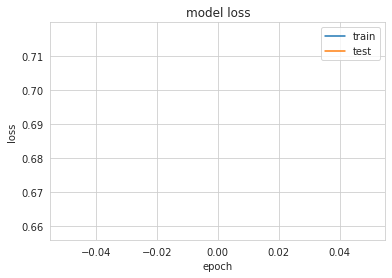

In [ ]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## AlexNet

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#The mean and standard deviation of the ImageNet data Alexnet was trained on.
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225] 

In [ ]:
test_size = 0.30
random_seed = 24
num_workers = 0
batch_size = 8

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize(256),    
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [ ]:
train_dataset = datasets.ImageFolder(root=TRAIN_DIR,
                                  transform=train_transform)

test_dataset = datasets.ImageFolder(root=TEST_DIR,
                                  transform=test_transform)

In [ ]:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
dataset_size2 = len(test_dataset)
indices2 = list(range(dataset_size2))

In [ ]:
train_idx, test_idx = indices, indices2

In [ ]:
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          sampler=test_sampler,
                                          num_workers=num_workers)

In [ ]:
dataloaders = {
    'train': train_loader,
    'test': test_loader
}

In [ ]:
# Finetuning the pretrained model
from torchvision import models

model = models.alexnet(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
num_ftrs = model.classifier[6].in_features
num_ftrs

4096

In [ ]:
#Redefining the last layer to classify inputs into the two classes we need as opposed to the original 1000 it was trained for.
model.classifier[6] = nn.Linear(num_ftrs, len(train_dataset.classes))

In [ ]:
criterion   = nn.CrossEntropyLoss()

optimizer   = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):

    model = model.to(device)
    total_step = len(dataloaders['train'])


    for epoch in range(num_epochs):
        print('epoch=',epoch)        

        for images, labels  in (dataloaders['train']):

                images = images.to(device)
                labels = labels.to(device)
    
                outputs = model(images)
                outputs = outputs.to(device)
                loss = criterion(outputs,labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        print('Epoch - %d, loss - %0.5f '\
            %(epoch, loss.item()))

    return model

In [ ]:
model = train_model(model, criterion, optimizer, num_epochs=10)

epoch= 0
Epoch - 0, loss - 0.03374 
epoch= 1
Epoch - 1, loss - 1.61682 
epoch= 2
Epoch - 2, loss - 0.39237 
epoch= 3
Epoch - 3, loss - 0.51395 
epoch= 4
Epoch - 4, loss - 0.74304 
epoch= 5
Epoch - 5, loss - 1.16611 
epoch= 6
Epoch - 6, loss - 0.12443 
epoch= 7
Epoch - 7, loss - 0.15076 
epoch= 8
Epoch - 8, loss - 0.13873 
epoch= 9
Epoch - 9, loss - 0.24404 


In [ ]:
# Model Evaluation
model.eval() #batchnorm or dropout layers will now work in eval mode instead of training mode.

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
torch.no_grad() #sets all the requires_grad flag to false and stops all gradient calculation.

In [ ]:
correct = 0
total = 0

for images, labels in dataloaders['test']:

    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the model on the test images: {}%'\
      .format(100 * correct / total))

Accuracy of the model on the test images: 82.08955223880596%


In [ ]:
inputs, labels = iter(dataloaders['test']).next()

inputs = inputs.to(device)
inp = torchvision.utils.make_grid(inputs)

outputs = model(inputs)
_, preds = torch.max(outputs, 1)

for j in range(len(inputs)):
    print ("Actual label", np.array(labels)[j])
    print ("Predict label", np.array(preds)[j])

    inp = inputs.data[j]
    # imshow(inp, 'predicted:' + class_names[preds[j]])

from sklearn.metrics import classification_report, confusion_matrix

Confusn_matrix_validation_set = confusion_matrix(labels, preds)

print("prediction is done on ",np.sum(Confusn_matrix_validation_set)," number of examples\n")
print('Confusion Matrix')
print(Confusn_matrix_validation_set)

import seaborn as sn
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix")
sn.heatmap(Confusn_matrix_validation_set, annot=True,fmt='g',annot_kws={"size": 16}, xticklabels = ['TB +Ve', 'TB -ve'], yticklabels = ['TB +Ve', 'TB -Ve'])

Actual label 0


TypeError: ignored

## VGG 19

In [ ]:
from keras.applications import VGG19
HEIGHT = 224
WIDTH = 224
CLASSES = 2
BATCH_SIZE = 32
 
base_model = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(HEIGHT, WIDTH, 3))

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.vgg19 import vgg19, preprocess_input

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

In [ ]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'vgg19.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

In [ ]:
# testing the model
model.evaluate_generator(validation_generator, steps=1,  max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

In [ ]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Summary:

In [ ]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Test loss", "Test Accuracy"]

x.add_row(["Inception V3", "0.56", "0.78"])
x.add_row(["VGG 19", "0.42", '0.78'])
x.add_row(["AlexNet", "0.5","0.82"])


print(x)

By observing from the above data, we can clearly conclude that VGG19 works best with highest test accuracy and lowest test loss. So we would proceed predictions with VGG19 model.

#### Predictions:

In [ ]:
# defining functions to visualise and test the data 


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]
  
def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("tb", "ntb")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [ ]:
# importing packages
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
model = load_model(MODEL_FILE)

In [ ]:
# visualizing a test case
img = image.load_img('test/tb/CHNCXR_0328_1.png', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [ ]:
# predicting the output of the images
y_pred = []

directory = 'test/tb/'
import os

for filename in os.listdir(directory):
    if filename.endswith(".png"): 
        img = image.load_img(directory + filename, target_size=(HEIGHT, WIDTH))
        preds = predict(model, img)
        y_pred.append(preds[0])
        continue
    else:
        continue

In [ ]:
# appending class levels to a list
path="test/"
tb_test = path + "tb/"

label_tb_t = []

for i in range(34):
    label_tb_t.append("1")

In [ ]:
# typecasting
labels = np.asarray(label_tb_t)
labels = labels.astype(int)

In [ ]:
y_pred_1 = np.asarray(y_pred).reshape(-1, 1)
from sklearn.preprocessing import binarize
# it will return 1 for all values above 0.7 and 0 otherwise
# results are 2D so we slice out the first column
y_pred_class = binarize(y_pred_1, 0.7)

In [ ]:
# 
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(labels, y_pred_class)

In [ ]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [ ]:
evaluate_threshold(0.8)

In [ ]:
Confusn_matrix_validation_set = metrics.confusion_matrix(labels, y_pred_class)
print(metrics.confusion_matrix(labels, y_pred_class))

import seaborn as sn
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix")
sn.heatmap(Confusn_matrix_validation_set, annot=True,fmt='g',annot_kws={"size": 16}, xticklabels = ['TB +Ve', 'TB -ve'], yticklabels = ['TB +Ve', 'TB -Ve'])

## OBSERVATION: 

1. Among all the models used Alexnet gave the a test accuracy of 82%
2. VGG19 model had lowest test loss of 0.42.